# Controle Digital

## 2ª Etapa do Trabalho Técnico (experimental)

### Lucas Jorjan (18150279)

## Fase 2 - Finalizando a montagem do trabalho experimental

Na imagem a seguir é apresentado a montagem do circuito:

![](montagemCircuito.jpeg)

Para o cálculo de velocidade de rotação do motor será utilizado um encoder com auxílio de um disco de 26mm com 20 furos. O enconder é um dispositivo eletromecânico que reproduz pulsos através da rotação de seu eixo. Eles são utilizados para conversão de movimentos rotativos em impulsos elétricos de onda quadrada. Este sinal é então lido pelo Arduino em uma das portas de entrada através de uma interrupção. Os pulsos então após serem lidos geram uma onda quadrada em uma determinada frequência que após os cálculos serão convertidos em velocidade. 

## Fase 3 - Realizando ensaios sobre o sistema

<ol>
<li>Obter a relação estática K do sistema;</li>
<li>obter a saída transitória de velocidade, a partir de uma onde quadrada de tensão.</li>
</ol>

Abaixo é apresentado o código em python que faz a comunicação serial com o arduino para gravar os dados de tensão e veocidade em um txt. Em seguida outro código no octave foi elaborado para fazer o plot ilustrado na figura abaixo.

```python

import serial
import sys
import time

ucontr = 'Arduino'
base_porta = '/dev/ttyUSB'
taxa = 115200
tempo = 500  #Timeout da conexao


#########################################################################
def procura_serial(porta, taxa, tempo):
    s = None
    for i in range(32):
        try:
            s = serial.Serial(porta + str(i), taxa, timeout=tempo)
        except serial.SerialException:
            continue
        else:
            break
    return s

#########################################################################
def sair(obj_serial):
    obj_serial.close()
    exit()

#########################################################################
def _data():
    return time.strftime('%d/%m/%Y %H:%M:%S')

#########################################################################
def amostragem(obj_serial, num):
    amostras = []
    try:
        for i in range(num):
            amostras.append(str(obj_serial.readline().rstrip(), 'utf8'))
    except KeyboardInterrupt:
        pass
    
    return amostras

#########################################################################

if __name__ == '__main__':
    s = procura_serial(base_porta, taxa, tempo)

    if not s:
        print('Impossível encontrar %s...' % ucontr)
        exit()
    else:
        print(ucontr + 'na porta' + str(s.port))


    arg = sys.argv[1:]

    arquivo = ''
    if len(arg) == 2:
        arquivo = arg[-1]

    if arg:
        arg = arg[0]
    else:
        print('Colocar número de amostras como argumento...')
        sair(s)

    try:
        leituras = int(arg)
        if leituras == 0:
            leituras = 2**64    #leitura 'infinita'
    except ValueError:
        print('Colocar número válido como argumento...')
        sair(s)


    print('Amostragem iniciada em ' + _data())

    amostras = amostragem(s, leituras)

    print('Amostragem terminada em ' + _data())

    if arquivo:
        open(arquivo, 'w').write(str(amostras))
        print(str(len(amostras)) + ' pontos salvos em ' + arquivo)

    sair(s)
```

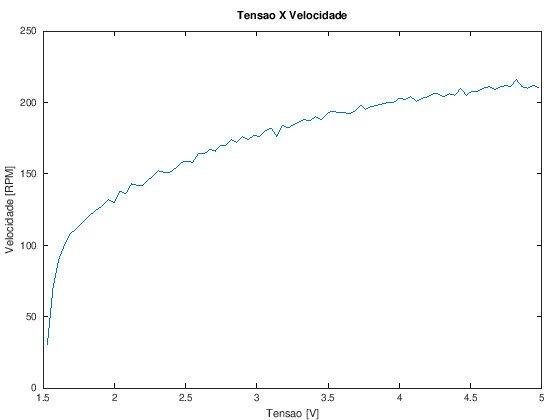

In [29]:
filename = "comunica.txt";
separator = ' ';
skipped_rows = 0;
skipped_columns = 0;
m = dlmread(filename, separator, skipped_rows, skipped_columns);
t = m(:,1);
eta_ = m(:, 2);
plot(t, eta_)
title('Tensao X Velocidade');
xlabel ("Tensao [V]");
ylabel ("Velocidade [RPM]");

![](graf1.png)

Escolhendo dois pontos da curva acima, a qual teoricamente deveria ser uma reta, é calculado o coeficiente angular (relação estática)

$$k = tan^-1((4.24 - 4.20)/(206-204))= 1.146$$

A seguir é apresentado o plotter serial da IDE do Arduino, onde foi colocado uma entrada em degrau de 1.96V e comparado com a velocidade medida pelo enconder.

![](graficoOndaQuadrada.png)

## Fase 4 - Projeto de Controle Digital

Foi escolhido um sistema de 1º ordem que se aproxima ao comportamente da curva, que tem caracteristicas de um
sistema 2º ordem sobreamortecido.

O sistema sobreamortecido com o $\zeta$ elevado se assemelha a de 1º ordem, validando assim a aproximação apesar dos picos de velocidade que ocorre esporadicamente. 

Para 1.96V, que é a tensão empregada no gráfico acima, o valor de RPM tende a estabilizar em 199 RPM como mostra a figura a seguir.

![](valorEstabilizado.png)

A constante de tempo ($\tau$) é o intervalo de tempo para que a resposta ao degrau unitário atinja 63,2% de seu valor final. O valor do tempo para achar $\tau$:

$$valorTempoTau= 199*0.632= 123.977$$

Como o valor muda bruscamente foi estimado um tempo de 0.60 segundos para $\tau$.

O motor de corrente contínua usado para realização dos testes pode ser modelado como um sistema de primeira ordem
do tipo:

$$ G(s) ≈ \frac{k}{\tau*s + 1}$$

Substituindo os valores de $\tau$,L e k a equação do sistema é apresentado a seguir:

$$\frac{1.146}{0.60*s+1}$$

### Resposta ao degrau do modelo proposto


Transfer function 'malha_fechada' from input 'u1' to output ...

          1.146    
 y1:  -------------
      0.6 s + 2.146

Continuous-time model.


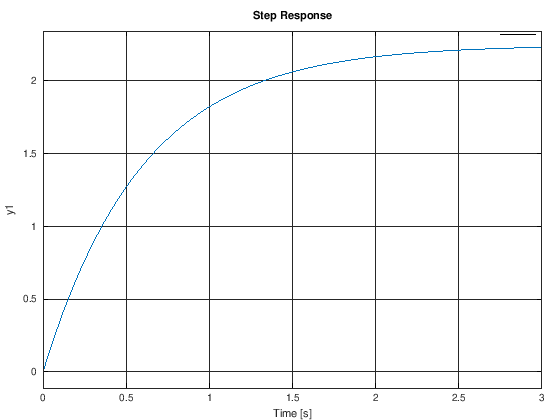

In [35]:
pkg load symbolic;
pkg load control;
syms s kp;

s = tf ('s');
v_entrada = 1.96; #tensão de entrada= 1.96 V
k = 1.146;
tau=0.60;
f_tf = k/(s*tau+1);
step(f_tf*v_entrada) # degrau de 1.96
malha_fechada = feedback(f_tf)

### Requisitos do sistema

<ol>
<li>0.02 < Ta < 0.8;</li>
<li>PSS < 15%;</li>
<li> 0.5 <= $\zeta$ <= 0.75;</li>
<li>Ts < Ta/10 de forma que tenha pelo menos 10 pontos.</li>  
</ol>

### Controlador PID
O controlador PID apresenta o seguinte formato matemático:

$ Gc(s) = Kp + Kd*s + Ki/s$

### O tempo de acomodação:
       
              Em malha aberta a planta é:
$$\frac{kp}{\tau*s+1}$$

              Em malha fechada na sua forma padrão é:
$$\frac{\frac{kp}{kp+1}}{\frac{\tau}{kp+1}*s + 1}$$

Para Ta = 0.8

$$\zeta*wn= \frac{4}{0.8}$$

Onde $\zeta*wn$ será utilizado para verificar um ponto no lugar das raízes entre 5 e 200 no eixo real. Para $\zeta$ entre 0.5 e 0.75 os ângulos no lugar das raizes serão 41.40° e 60°.

O ponto escolhido no lugar das raízes de acordo com os requisitos foi 15 + 15j, posteriormente foi escolhendo dois zeros complexos conjugados. É encontrado a posição dos zeros através da condição de ângulo tal que o Lugar das Raízes passe pelo ponto escolhido. Fazendo os cálculos para os zeros:

$$ Fab = arctg((15 + b)/(-15 + a)) + arctg((15 - b)/(-15+a)) = 91.97°   $$

Assumindo a=100 o valor de b será 81i. Por fim, o controlador PID será igual a:

$$CPID(s)= \frac{0.25*(s^2 + 2*(100)*s + 100^2 + (84i)^2)}{(s*((1/1000)*s +1))}$$

Onde k= 0.25 para o posicionamento no ponto escolhido.

### Resposta ao degrau de malha fechada com o controlador PID:


Transfer function 'fMalhaFechada' from input 'u1' to output ...

            0.2865 s^2 + 57.3 s + 843.5       
 y1:  ----------------------------------------
      0.0006 s^3 + 0.8875 s^2 + 58.3 s + 843.5

Continuous-time model.


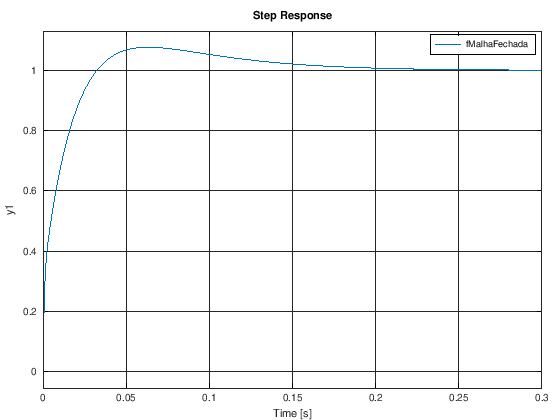

In [83]:
pkg load symbolic;
pkg load control;
s = tf ('s');
k = 1.146;
tau=0.60;
f_tf = k/(s*tau+1);
C_s = 0.25*(s^2 + 2*(100)*s + 100^2 + (84i)^2) / (s*((1/1000)*s +1));
f_com_C_s = f_tf*C_s;
fMalhaFechada=feedback(f_com_C_s)
step(fMalhaFechada)


O gráfico do PID cumpre com os requisitos propostos, visto que seu PSS não ultrapassa 15% e seu tempo de acomodação acontece antes de 0.8 segundos.

### Transformação por ZOH:

In [87]:
pkg load symbolic;
pkg load control;s = tf ('s');
k = 1.146;
tau=0.60;
f_tf = k/(s*tau+1);
C_s = 0.25*(s^2 + 2*(100)*s + 100^2 + (84i)^2) / (s*((1/1000)*s +1));
f_com_C_s = f_tf*C_s;
fMalhaFechada=feedback(f_com_C_s);
Fdigital = c2d(fMalhaFechada,0.08,'zoh')


Transfer function 'Fdigital' from input 'u1' to output ...

           1.069 z^2 - 0.2727 z + 0.001309     
 y1:  -----------------------------------------
      z^3 - 0.2064 z^2 + 0.004285 z - 3.797e-19

Sampling time: 0.08 s
Discrete-time model.


### Controlador deadbeat

Foi projetado um controlador deadbeat com dois passos e tempo de amostragem 0.8 segundos. Para este tempo de amostragem, a planta discretizada com ZOH é apresentada abaixo:

In [93]:
k = 1.146;
tau=0.60;
f_tf = k/(s*tau+1);
FdigitalMalhaAberta = c2d(f_tf,0.08,'zoh')


Transfer function 'FdigitalMalhaAberta' from input 'u1' to output ...

        0.1431  
 y1:  ----------
      z - 0.8752

Sampling time: 0.08 s
Discrete-time model.


O controlador é dado pela fórmula:

$$ C(z) = \frac{K*Nc(z)}{(z − 1)Dc(z)} ;$$

Fazendo $Nc(z) = Dg(z)$ e escolhendo $Dc(z) = z − bo$

$$ K*Ng(z)+(z−1)(z−bo) = K(0.1431)+(z−1)(z−bo) = z^2 ; $$

Para igualdade, temos que:

\begin{equation}
  \left\{ \begin{aligned}
     \ -bo-1=0 \\
       0.1431*k+bo=0\\
  \end{aligned} \right.
\end{equation}

bo = -1 e k = 6.988

Então o controlador deadbeat fica:

$$ C(z) = \frac{6.988(z - 0.8752)}{(z − 1)(z + 1)} ;$$

In [104]:
k = 1.146;
tau=0.60;
f_tf = k/(s*tau+1);
FdigitalMalhaAberta = c2d(f_tf,0.08,'zoh');
z = tf ('z', 0.08);
controladorDeadbeat = 6.988*(z - 0.8752)/((z-1)*(z+1));
fdeadbeat_fechada = FdigitalMalhaAberta*controladorDeadbeat


Transfer function 'fdeadbeat_fechada' from input 'u1' to output ...

            0.9996 z - 0.8749      
 y1:  -----------------------------
      z^3 - 0.8752 z^2 - z + 0.8752

Sampling time: 0.08 s
Discrete-time model.


## Fase 5 - Implementação dos Controladores

### Equação PID recursiva

$$ y[k]*(y[k] -0.2064*y[k-1] + 0.004285*y[k-2]) = u[k]*(1.069*y[k-1] - 0.2727*y[k-2] + 0.001309*y[k-3]) $$

### Equação Deadbeat recursiva

$$ y[k]*(y[k] - 0.8752*y[k] - y[k-2] + 0.8752*y[k-3]) = u[k]*(0.9996*y[k-2]- 0.8749*y[k-3]) $$

### Passos para aplicação

1. Obter valores do sensor;
2. Calcular o sinal de controle u[k];
3. Enviar o sinal de controle u[k];
4. Esperar o delay a cada intereção.

Abaixo é ilustrado o plot serial do arduino, onde foi aplicado o controlador PID no motor. Foi setado para que se estabiliza-se em 375 RPM, que não ocorre porém tende a se manter perto do valor projetado.

![](plotSerial.png)

### Conclusão

A estrutura de um trabalho de controle quando abordado pelo lado prático é dependente em grande parte da disponibilidade de equipamentos e recursos apropriados. O propósito deste trabalho é de empregar o conhecimento em controle para controlar um motor DC. O trabalho teve seu segmento com as simulações, cálculos e por fim o projeto do controlador no Arduino, que não teve os resultados esperados. No caso do controlador PID por exemplo o valor não estabiliza, isso ocorre devido a falta de precisão dos equipamentos a cada iteração e possivelmente na abordagem dos parametros escolhidos.